<a href="https://colab.research.google.com/github/kenairr/Endogrip/blob/main/Wrist_Angle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Time Spent Exceeding Thresholds:
         Barehand (s)  Endogrip (s)
>26.6°         101.08        154.48
>32.7°          90.08         78.64
<-37.7°          3.33          0.00
<-48.6°          1.01          0.00


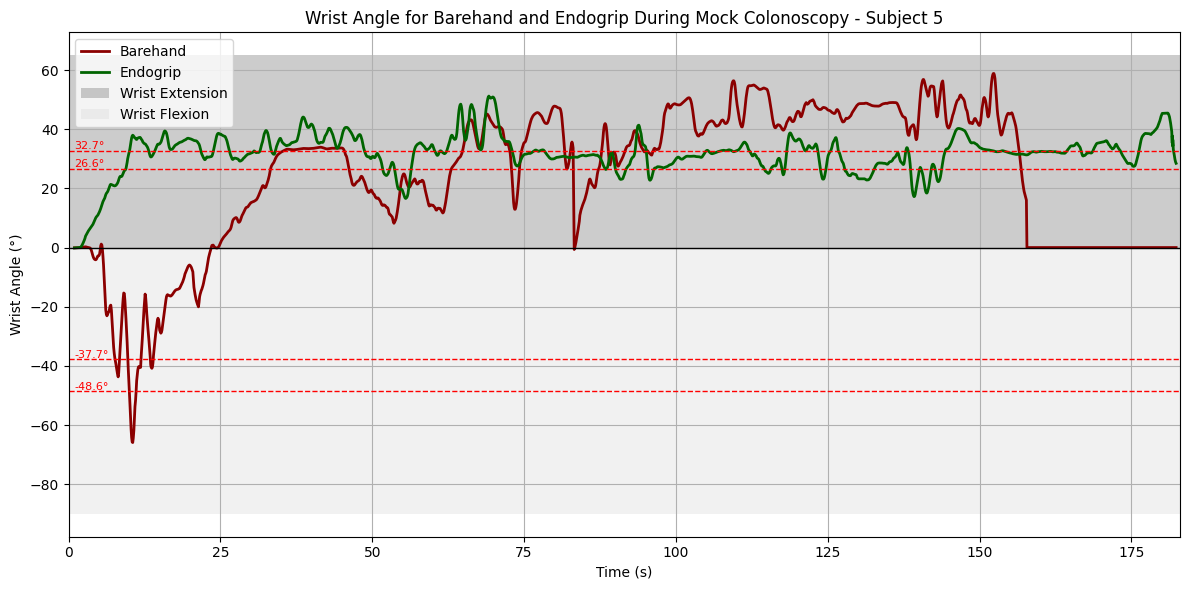

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Read CSV (3 columns: Time, Barehand, Endogrip)
df = pd.read_csv('/content/drive/MyDrive/wrist angles - subject 5.csv', encoding='windows-1252')
df.columns = ['Time', 'Barehand', 'Endogrip']

# Clean degree symbols and convert to float
df['Barehand'] = df['Barehand'].str.replace('°', '', regex=False).astype(float)
df['Endogrip'] = df['Endogrip'].str.replace('°', '', regex=False).astype(float)
df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df = df.sort_values('Time').dropna()

# Time intervals
df['dt'] = df['Time'].diff().fillna(0)

# Thresholds
upper_thresholds = [26.6, 32.7]
lower_thresholds = [-37.7, -48.6]
all_thresholds = upper_thresholds + lower_thresholds

# Function to calculate time exceeding thresholds
def calculate_violation_duration(signal, dt_column, thresholds, direction):
    durations = {}
    for t in thresholds:
        label = f'>{t}°' if direction == 'above' else f'<{t}°'
        if direction == 'above':
            mask = signal > t
        else:
            mask = signal < t
        durations[label] = df[dt_column][mask].sum()
    return durations

# Calculate durations for each grip
barehand_durations = {
    **calculate_violation_duration(df['Barehand'], 'dt', upper_thresholds, 'above'),
    **calculate_violation_duration(df['Barehand'], 'dt', lower_thresholds, 'below')
}
endogrip_durations = {
    **calculate_violation_duration(df['Endogrip'], 'dt', upper_thresholds, 'above'),
    **calculate_violation_duration(df['Endogrip'], 'dt', lower_thresholds, 'below')
}

# Combine into DataFrame
duration_summary = pd.DataFrame({
    'Barehand (s)': pd.Series(barehand_durations),
    'Endogrip (s)': pd.Series(endogrip_durations)
})

print("Time Spent Exceeding Thresholds:")
print(duration_summary)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Barehand'], label='Barehand', color='darkred', linewidth=2)
plt.plot(df['Time'], df['Endogrip'], label='Endogrip', color='darkgreen', linewidth=2)
ymin, ymax = plt.ylim()
plt.axhspan(0, 65, facecolor='grey', alpha=0.4, label='Wrist Extension')
plt.axhspan(-90, 0, facecolor='lightgrey', alpha=0.3, label='Wrist Flexion')
for t in all_thresholds:
    plt.axhline(y=t, color='red', linestyle='--', linewidth=1)
    plt.text(df['Time'].min(), t + 0.5, f'{t}°', color='red', fontsize=8)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.title('Wrist Angle for Barehand and Endogrip During Mock Colonoscopy - Subject 5')
plt.xlabel('Time (s)')
plt.ylabel('Wrist Angle (°)')
plt.xlim(0,183)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
subjects = [5, 7, 8, 9, 10]
thresholds = [26.6, 32.7, -37.7, -48.6]
base_path = '/content/drive/MyDrive/'

def process_subject(subject_id):
    file_path = os.path.join(base_path, f"wrist angles - subject {subject_id}.csv")
    try:
        df = pd.read_csv(file_path, encoding='windows-1252')
        df.columns = ['Time', 'Barehand', 'Endogrip']

        if df['Barehand'].dtype == 'object':
            df['Barehand'] = df['Barehand'].str.replace('°', '', regex=False).astype(float)
        else:
            df['Barehand'] = df['Barehand'].astype(float)

        if df['Endogrip'].dtype == 'object':
            df['Endogrip'] = df['Endogrip'].str.replace('°', '', regex=False).astype(float)
        else:
            df['Endogrip'] = df['Endogrip'].astype(float)

        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
        df = df.sort_values('Time').dropna()
        df['dt'] = df['Time'].diff().fillna(0)

        # Calculate time exceeding each threshold
        results = {'Subject': f'Subject {subject_id}'}
        for t in [26.6, 32.7]:
            results[f'>{t}° Barehand (s)'] = df['dt'][df['Barehand'] > t].sum()
            results[f'>{t}° Endogrip (s)'] = df['dt'][df['Endogrip'] > t].sum()
        for t in [-37.7, -48.6]:
            results[f'<{t}° Barehand (s)'] = df['dt'][df['Barehand'] < t].sum()
            results[f'<{t}° Endogrip (s)'] = df['dt'][df['Endogrip'] < t].sum()

        results['Total Time Barehand (s)'] = df['dt'][df['Barehand'] != 0].sum()
        results['Total Time Endogrip (s)'] = df['dt'][df['Endogrip'] != 0].sum()

        plt.figure(figsize=(10, 5))
        plt.plot(df['Time'], df['Barehand'], label='Barehand', color='darkred')
        plt.plot(df['Time'], df['Endogrip'], label='Endogrip', color='darkgreen')

        for t in thresholds:
            plt.axhline(y=t, color='red', linestyle='--', linewidth=1)
            plt.text(df['Time'].min(), t + 0.5, f'{t}°', color='red', fontsize=8)

        plt.axhspan(0, 90, facecolor='grey', alpha=0.2, label='Wrist Extension')
        plt.axhspan(-90, 0, facecolor='lightgrey', alpha=0.2, label='Wrist Flexion')
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

        plt.title(f"Wrist Angle for Barehand and Endogrip During Mock Colonoscopy - Subject {subject_id}")
        plt.xlabel("Time (s)")
        plt.ylabel("Wrist Angle (°)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        save_path = os.path.join(base_path, f"Subject_{subject_id}_Wrist_Angle.png")
        plt.savefig(save_path)
        plt.close()

        return results

    except Exception as e:
        print(f"Error processing Subject {subject_id}: {e}")
        return None

summary = []
for sid in subjects:
    result = process_subject(sid)
    if result:
        summary.append(result)

summary_df = pd.DataFrame(summary)
pd.set_option('display.float_format', '{:.2f}'.format)
print("Time Spent Exceeding Wrist Angle Thresholds:\n")
print(summary_df.to_string(index=False))
flipped_df = summary_df.set_index('Subject').T

print("\nFlipped Summary Table (Metrics as Rows):")
print(flipped_df.to_string())

flipped_df.to_csv(os.path.join(base_path, 'Wrist_Angle_Threshold_Summary_Flipped.csv'))

Time Spent Exceeding Wrist Angle Thresholds:

   Subject  >26.6° Barehand (s)  >26.6° Endogrip (s)  >32.7° Barehand (s)  >32.7° Endogrip (s)  <-37.7° Barehand (s)  <-37.7° Endogrip (s)  <-48.6° Barehand (s)  <-48.6° Endogrip (s)  Total Time Barehand (s)  Total Time Endogrip (s)
 Subject 5               101.08               154.48                90.08                78.64                  3.33                  0.00                  1.01                  0.00                   156.73                   181.38
 Subject 7                 0.00                10.81                 0.00                 0.00                  0.00                  0.00                  0.00                  0.00                   180.84                    75.65
 Subject 8                 3.24                12.67                 2.96                 9.14                  7.95                 12.76                  5.17                 11.47                   188.46                   129.27
 Subject 9            

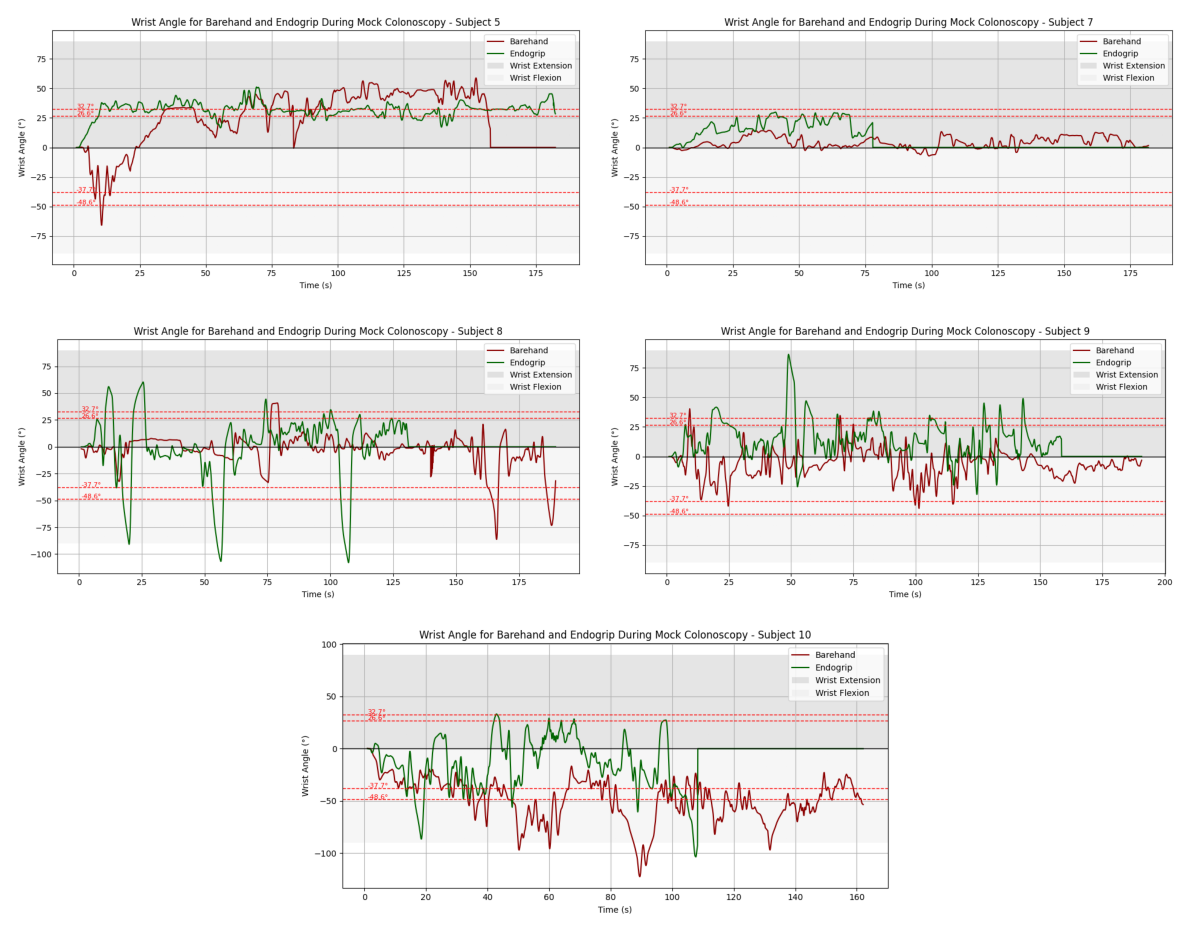

In [ ]:
# Subjects and base path
subjects = [5, 7, 8, 9, 10]
base_path = '/content/drive/MyDrive/'

fig = plt.figure(figsize=(12, 10))
for idx, subject_id in enumerate(subjects[:4]):
    ax = fig.add_subplot(3, 2, idx + 1)
    img_path = os.path.join(base_path, f"Subject_{subject_id}_Wrist_Angle.png")

    if not os.path.exists(img_path):
        print(f"Image for Subject {subject_id} not found.")
        ax.axis('off')
        continue

    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

ax = fig.add_subplot(3, 1, 3)
subject_id = 10
img_path = os.path.join(base_path, f"Subject_{subject_id}_Wrist_Angle.png")

if os.path.exists(img_path):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
else:
    print(f"Image for Subject {subject_id} not found.")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])

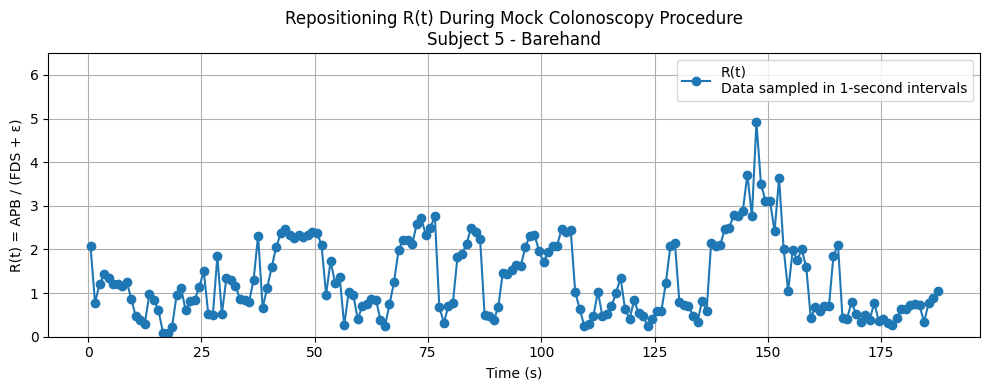

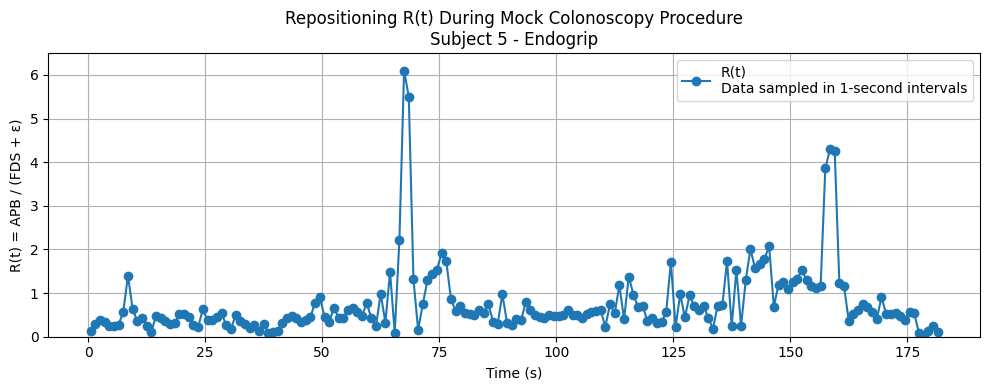

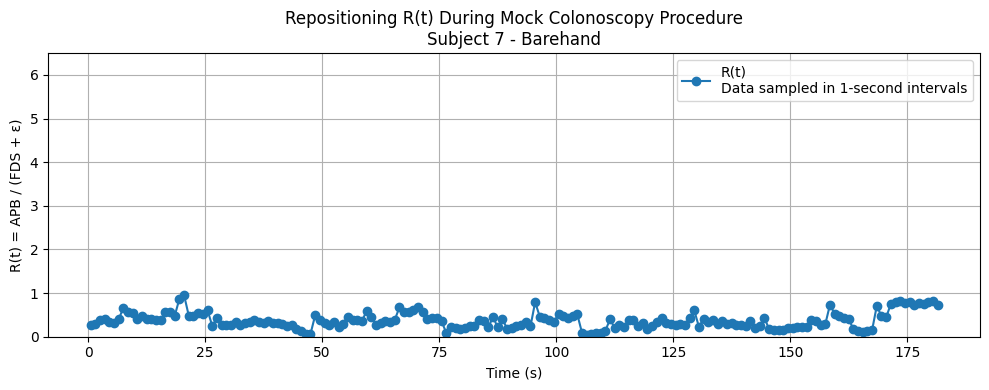

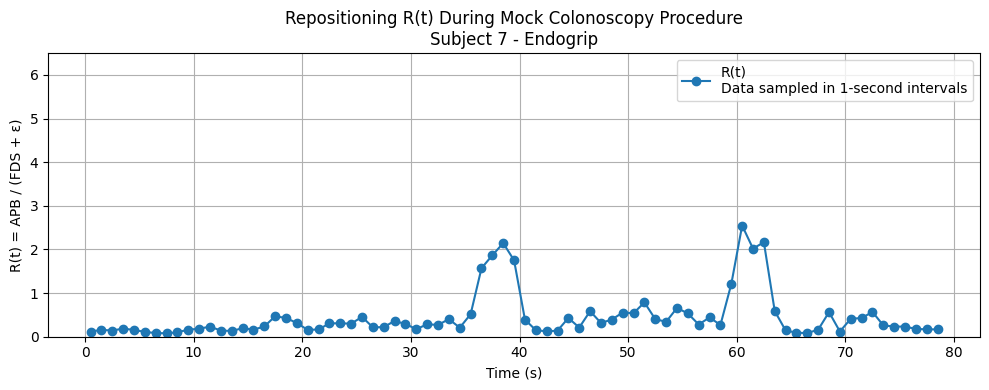

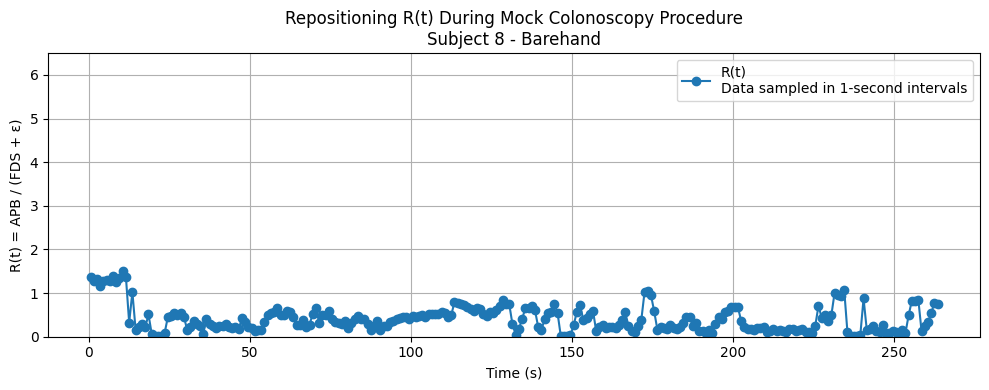

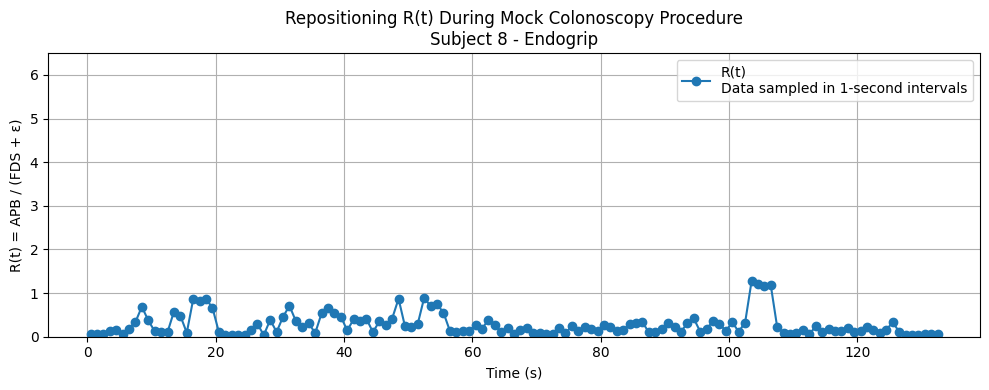

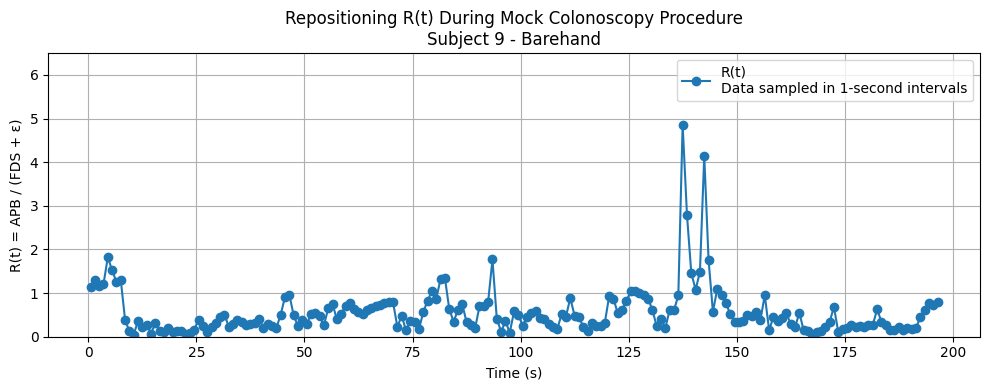

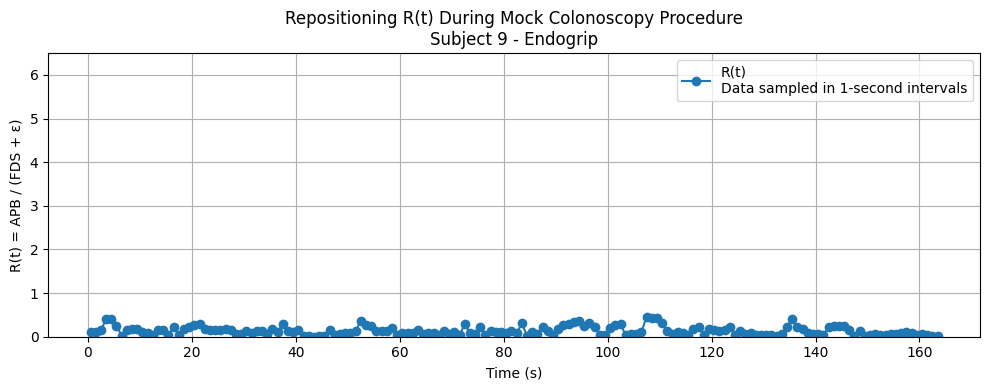

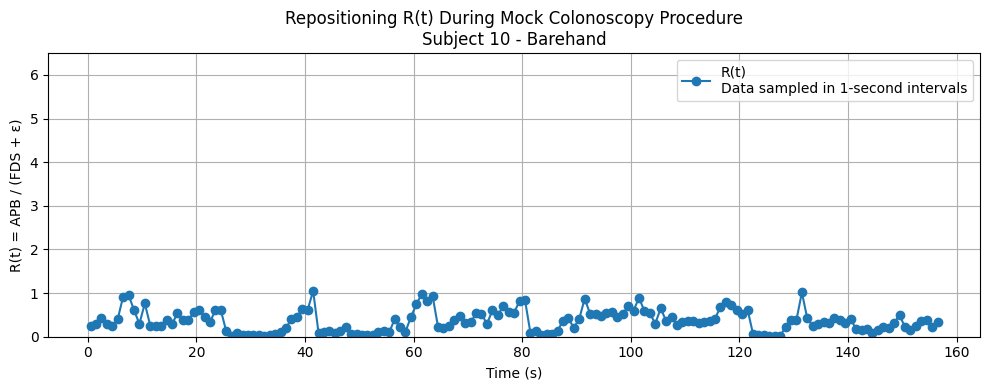

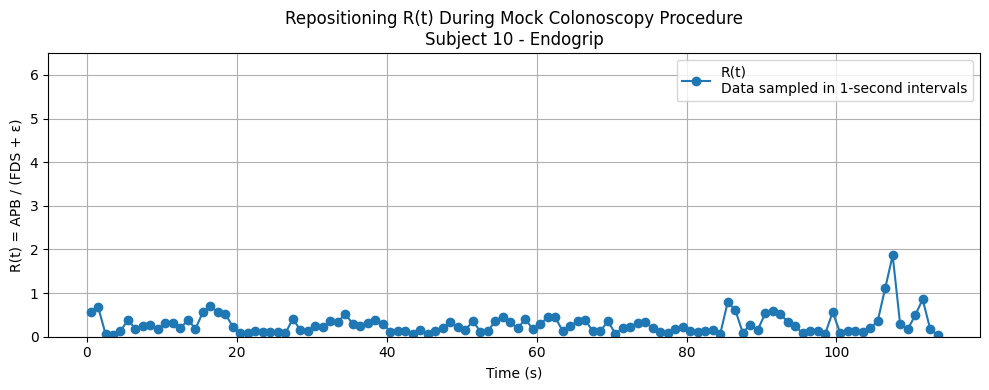

In [ ]:
base_dir = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing "
subfolder = "Mock Colonoscopy"
output_dir = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Analysis Output"
os.makedirs(output_dir, exist_ok=True)

subjects = [5, 7, 8, 9, 10]
conditions = ['barehand', 'endogrip']
apb_col = 1  # APB in column 2
fds_col = 3  # FDS in column 4
epsilon = 1e-6
interval_duration = 1  # seconds

for subject in subjects:
    for condition in conditions:
        filename = f"{condition}_envelope_subject_{subject}.xlsx"
        filepath = os.path.join(base_dir, f"Subject_{subject}", subfolder, filename)

        try:
            df = pd.read_excel(filepath)

            time = df.iloc[:, 0]
            apb = df.iloc[:, apb_col]
            fds = df.iloc[:, fds_col]

            max_time = time.max()
            intervals = np.arange(0, max_time, interval_duration)

            rows = []
            midpoints = []  # for plotting x-axis

            for start_time in intervals:
                end_time = start_time + interval_duration
                mask = (time >= start_time) & (time < end_time)

                if mask.sum() == 0:
                    continue  # Skip empty intervals

                apb_mean = apb[mask].mean()
                fds_mean = fds[mask].mean()
                ratio = apb_mean / (fds_mean + epsilon)

                rows.append({
                    "Time Interval (s)": f"{start_time:.1f} - {end_time:.1f}",
                    "Mean APB": apb_mean,
                    "Mean FDS": fds_mean,
                    "R(t) = APB/FDS": ratio
                })

                midpoints.append((start_time + end_time) / 2)

            result_df = pd.DataFrame(rows)

            # Save to CSV
            csv_filename = f"R_ratio_subject_{subject}_{condition}.csv"
            result_df.to_csv(os.path.join(output_dir, csv_filename), index=False)

            # Plot R(t) over time
            plt.figure(figsize=(10, 4))
            plt.plot(midpoints, result_df["R(t) = APB/FDS"], marker='o', label='R(t)\nData sampled in 1-second intervals')
            plt.title(f"Repositioning R(t) During Mock Colonoscopy Procedure\nSubject {subject} - {condition.capitalize()}")
            plt.xlabel("Time (s)")
            plt.ylabel("R(t) = APB / (FDS + ε)")
            plt.ylim(0,6.5)
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Error processing Subject {subject} ({condition}): {e}")
